In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../data/train.csv', index_col=0)

In [3]:
print(df.columns)
print(df.shape)

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')
(891, 11)


In [4]:
df.sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
371,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,C
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
232,0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,NaN,S
373,0,3,"Beavan, Mr. William Thomas",male,19.0,0,0,323951,8.0500,NaN,S
731,1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S


In [5]:
# The age column has nas, but they don't seem special at first sight.
# I'll fill them with the median

df[df['Age'].isnull()].sample(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
49,0,3,"Samaan, Mr. Youssef",male,NaN,2,0,2662,21.6792,NaN,C
827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S


In [6]:
# Substitute missing ages with the median (28)

def replace_nas_with_median(dataframe, column):
    clean_column = dataframe[column][:]
    median_value = clean_column.median()
    clean_column[clean_column.isnull()] = median_value
    
    dataframe[column] = clean_column

In [7]:
discrete_columns = ['Pclass','Sex', 'Cabin', 'Embarked']

# Workaround to get pandas to behave as I want
# Otherwise it keeps multilevel integer variables in a single column
def one_hot(dataframe, discrete_columns):
    
    # Encode cabin as 'data present' vs 'absent'
    dataframe['Cabin'] = ~dataframe['Cabin'].isnull()
    
    dummies = []
    for column in discrete_columns:
        these_dummies = pd.get_dummies(dataframe[column], prefix=column, drop_first=True)
        dummies.append(these_dummies)
        
        
    return pd.concat(dummies, axis=1)
    
discrete = one_hot(df, discrete_columns)

In [8]:
continuous_columns = ['Age', 'Fare']

def normalize_continuous(dataframe, continuous_columns):
    continuous = dataframe[continuous_columns]
    
    for column in continuous_columns:
        replace_nas_with_median(continuous, column)
        
    return (continuous - continuous.mean()) / (continuous.max() - continuous.min())

continuous_normalized = normalize_continuous(df, continuous_columns)

/home/dani/anaconda3/envs/titanic/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
features = pd.concat([discrete, continuous_normalized], axis=1)

In [10]:
features['Age'].isnull().sum()

0

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, df['Survived'], test_size=0.3)

print(X_train.shape)
print(X_test.shape)

(623, 8)
(268, 8)


In [12]:
from sklearn.ensemble.forest import RandomForestClassifier

forest = RandomForestClassifier()
model = forest.fit(X_train, Y_train)
predicted_probs = model.predict_proba(X_test)[:,1]
predicted_class = model.predict(X_test)

In [13]:
from sklearn import metrics

roc = metrics.roc_curve(Y_test, predicted_probs)
print(metrics.roc_auc_score(Y_test, predicted_probs))
print(metrics.f1_score(Y_test, predicted_class))

0.843314804853
0.717948717949


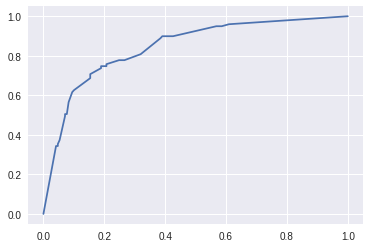

In [14]:
ax = plt.plot(roc[0],roc[1])

Decent enough! Let's play around a bit more

In [15]:
# Let's use cross validation to waste less data and compare to an svm:
from sklearn.model_selection import cross_val_predict

rf_predictions = cross_val_predict(forest, features, df['Survived'], cv=10)


from sklearn import svm

SVM = svm.SVC(kernel='linear', C=1)

svm_predictions = cross_val_predict(SVM, features, df['Survived'], cv=10)

In [16]:
print(metrics.f1_score(df['Survived'], rf_predictions))
print(metrics.accuracy_score(df['Survived'], rf_predictions))
print(metrics.f1_score(df['Survived'], svm_predictions))
print(metrics.accuracy_score(df['Survived'], svm_predictions))

0.743902439024
0.811447811448
0.710365853659
0.786756453423


In [17]:
def process_features(path):
    df = pd.read_csv(path, index_col=0)
    df_continuous = normalize_continuous(df, continuous_columns)
    df_discrete = one_hot(df, discrete_columns)
    df_features = pd.concat([df_discrete, df_continuous], axis=1)
    
    return df_features
    
def generate_submission(model, submission_features):
    submission_predictions = model.predict(submission_features)
    submission = pd.DataFrame(submission_predictions, index=submission_features.index, columns=['Survived'])
    submission.to_csv('../data/submission.csv')
    
    
submission_features = process_features('../data/test.csv')
model = forest.fit(features, df['Survived'])
generate_submission(model, submission_features)

/home/dani/anaconda3/envs/titanic/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
# Once I fixed a stupid mistake, this got 0.708


## Logistic regression

In [19]:
from sklearn.linear_model import LogisticRegressionCV

logistic_model = LogisticRegressionCV()

model = logistic_model.fit(X_train, Y_train)

logit_predictions = model.predict(X_test)

print(metrics.f1_score(Y_test, logit_predictions))
print(metrics.accuracy_score(Y_test, logit_predictions))

0.698924731183
0.791044776119


## For reference: really basic prediction:

In [20]:
female = 1 - features['Sex_male']

In [21]:
print(metrics.f1_score(df['Survived'], female))
print(metrics.accuracy_score(df['Survived'], female))

0.710365853659
0.786756453423


mmm this makes my RF and SVM look like shit. Even worse, the gender_submission scores 0.7655

Sad

## Let's try to refine the RF

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100)

rf_clf.fit(X_train, Y_train)

print(metrics.f1_score(Y_test, rf_clf.predict(X_test)))
print(metrics.accuracy_score(Y_test, rf_clf.predict(X_test))) # This is the score that the .score() method returns

0.710659898477
0.787313432836


In [23]:
training_features = process_features('../data/train.csv')
submission_features = process_features('../data/test.csv')

rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(training_features, df['Survived'])

generate_submission(rf_clf, submission_features)

# this got 0.69... overfitting much?

/home/dani/anaconda3/envs/titanic/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Ok what the fuck is going on here? Let's actually have a luck at the data, from scratch

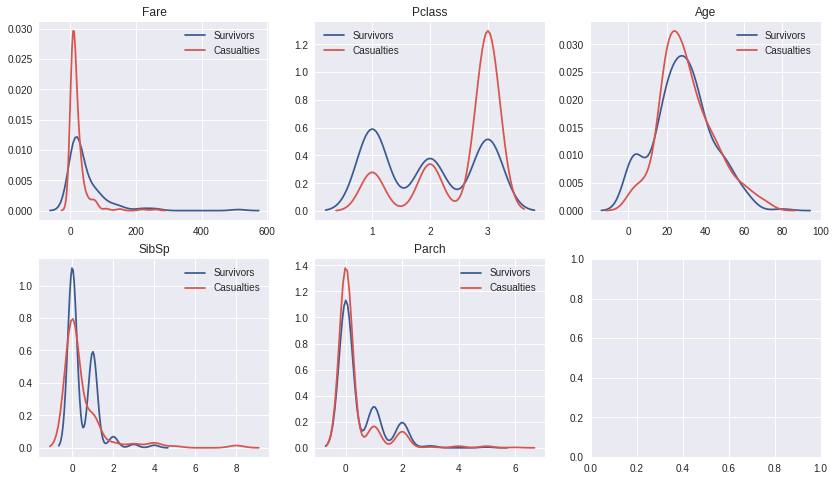

In [24]:
# Most important variables: socioeconomic status and gender

df = pd.read_csv('../data/train.csv', index_col=0)

survivors = df[df['Survived']==1]
casualties = df[df['Survived']!=1]
variables_to_plot = ['Fare', 'Pclass', 'Age', 'SibSp', 'Parch']
f, axes = plt.subplots(2,3)

for i, var in enumerate(variables_to_plot):
    ax = axes[int(i/3)][int(i%3)]
    
    
    sns.kdeplot(survivors[var].dropna(), color=sns.xkcd_rgb['denim blue'], label='Survivors', ax=ax)
    sns.kdeplot(casualties[var].dropna(), color=sns.xkcd_rgb['pale red'], label='Casualties', ax=ax)
    ax.set_title(var)

f.set_size_inches(14, 8)
#_ = plt.xlim(-20, 125)

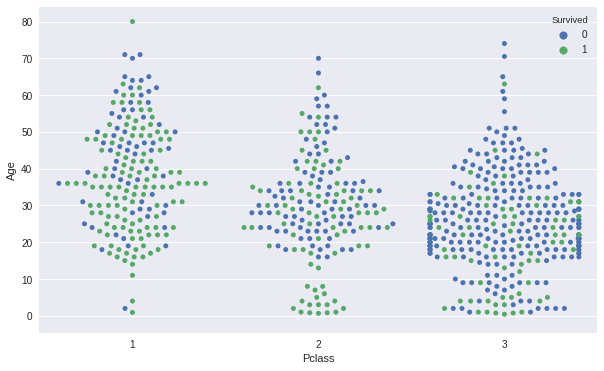

In [25]:
sns.swarmplot(data=df, x='Pclass', y='Age' , hue='Survived'),

plt.gcf().set_size_inches(10,6)

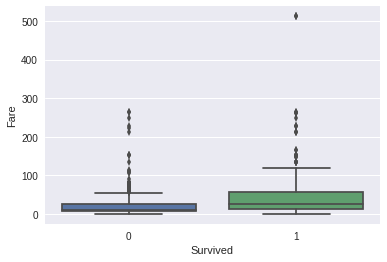

In [26]:
sns.boxplot(x='Survived', y='Fare', data=df)

In [27]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [29]:
## Stacked bar plots

# Not inclulded in seaborn
# use http://matplotlib.org/examples/pylab_examples/bar_stacked.html
# or http://randyzwitch.com/creating-stacked-bar-chart-seaborn/